# Final bachelor's Project
## Section one: EEG Epilepsy Preprocessing
### Author: Pouya Taghipour
### Studend ID: 9933014
### Supervisors: 
- Dr. Farnaz Ghassemi
- Dr. Fatemeh Zare
- Dr. Zahra Tabanfar
### Date: Summer 2024


# Seizure Prediction and Detection: Data Preprocessing and Exploration
In this project, we will work with the CHB-MIT Scalp EEG database, a widely used dataset for seizure prediction and detection. The dataset contains EEG recordings from pediatric subjects with intractable seizures. This guide will walk you through the steps of cleaning, preprocessing, and visualizing the data to gain a deeper understanding of its structure and characteristics.

## Importing Libraries
First, we need to import the necessary libraries for data manipulation, signal processing, and visualization.

In [1]:
# @markdown Installing the initials
! pip install mne numpy pandas scipy matplotlib 

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 7.4/7.4 MB 160.8 kB/s eta 0:00:00
     -------------------------------------- 64.6/64.6 kB 434.7 kB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Imports


In [3]:
import os  # For operating system interactions
import mne  # For EEG/MEG data processing
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation
from scipy.stats import kurtosis, skew  # For statistical calculations
from scipy.signal import welch  # For signal processing
from scipy.integrate import cumtrapz  # For cumulative integration
import time  # For timing execution
import matplotlib.pyplot as plt  # For plotting
import statistics
import seaborn as sns

Set default plotting setting

In [4]:
plt.style.use('seaborn-darkgrid')

C:\Users\Pouya\AppData\Local\Temp\ipykernel_24836\448178554.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


## Loading the CHB-MIT EEG Data

We will load the EEG data using the MNE library, which provides convenient functions to work with EEG datasets.

In [8]:
# Define the file path to the EEG data (update with your path)
file_path = r'C:\Users\Pouya\Documents\university\Bachelor - AUT\Final Project\Data Set\EEG Scalp MIT\Data\chb01\chb01_05.edf'

# Load the data
raw_data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)

# Display basic information about the data
raw_data.info

C:\Users\Pouya\AppData\Local\Temp\ipykernel_24836\563888296.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw_data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


Measurement date,"November 06, 2076 15:43:19 GMT"
Experimenter,Unknown
Participant,Surrogate
Digitized points,Not available
Good channels,23 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.00 Hz
Lowpass,128.00 Hz


## Data Overview and Visualization

Before diving into preprocessing, let's explore the data to understand its structure.

### Plotting Raw EEG Signals

We'll visualize the raw EEG signals to inspect their characteristics.

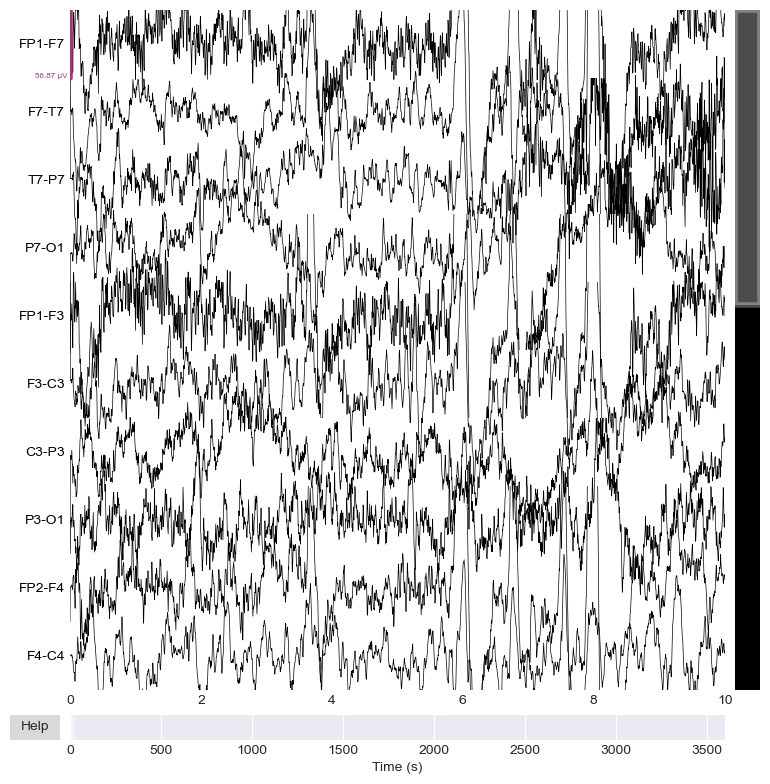

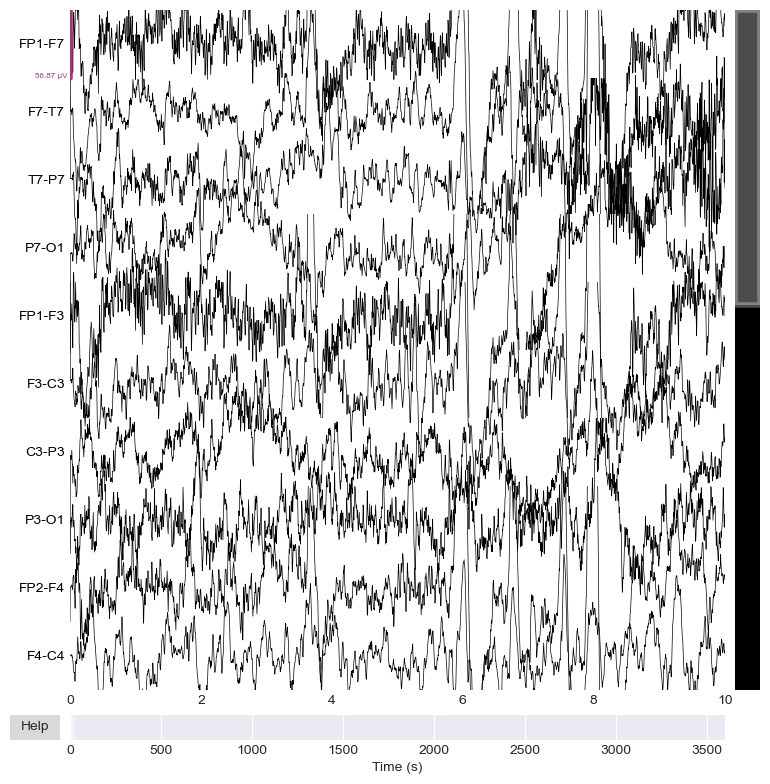

In [9]:
# Plot raw EEG signals
raw_data.plot(n_channels=10, scalings='auto', title='Raw EEG Signals', show=True)

### Exploring Channel Names and Sampling Frequency
It's essential to know the channel names and sampling frequency of the recordings.

In [10]:
# Display channel names
print("Channel names:", raw_data.ch_names)

# Display the sampling frequency
print("Sampling frequency:", raw_data.info['sfreq'], "Hz")

Channel names: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
Sampling frequency: 256.0 Hz


## Preprocessing
Preprocessing is crucial to clean the data and prepare it for analysis. This step includes filtering, downsampling, and handling missing data or artifacts.

### Filtering the Data
We will apply a bandpass filter to remove noise and artifacts. Typically, EEG signals are filtered between 0.5 Hz and 40 Hz.

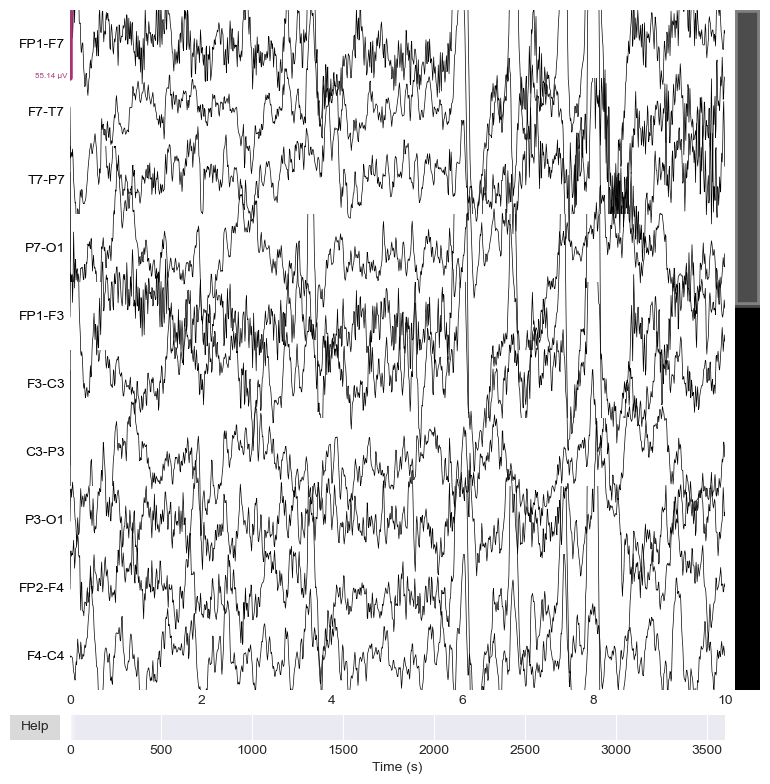

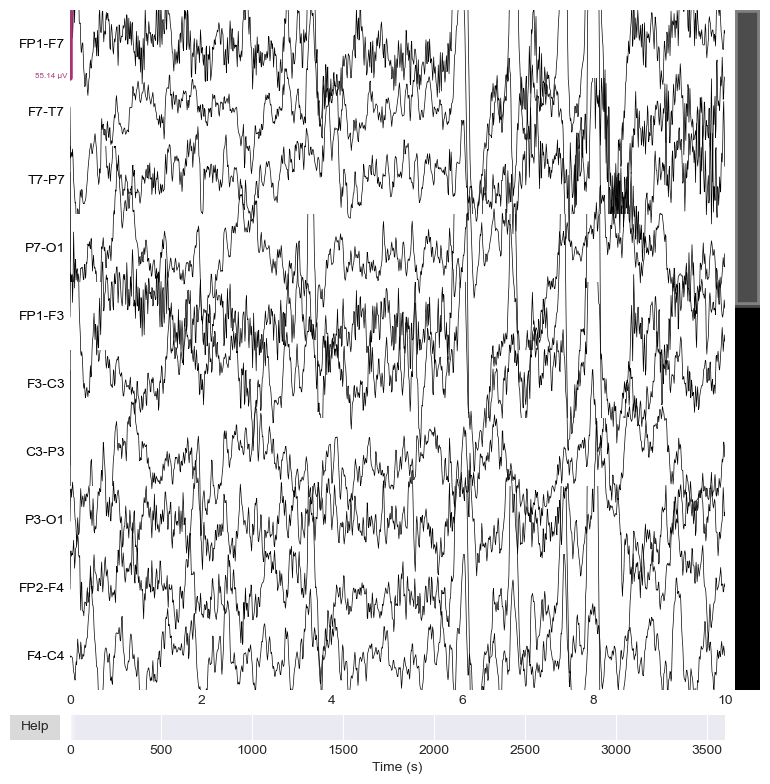

In [11]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=256.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Apply bandpass filter to the data
filtered_data = raw_data.copy().filter(0.5, 40.0, fir_design='firwin', verbose=False)

# Plot the filtered signals
filtered_data.plot(n_channels=10, scalings='auto', title='Filtered EEG Signals', show=True)

### Downsampling
If the data has a high sampling rate, downsampling can reduce the computational load.

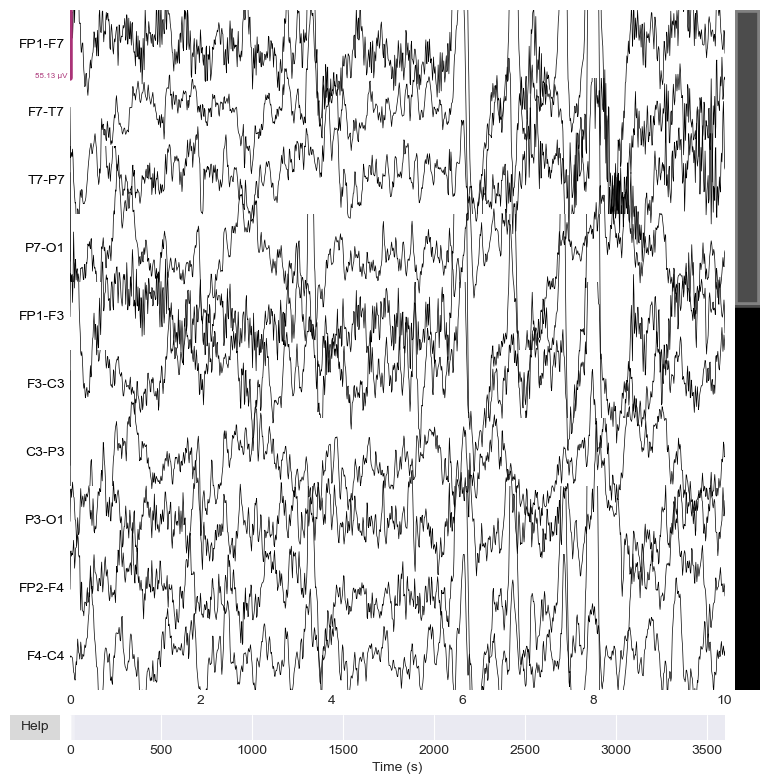

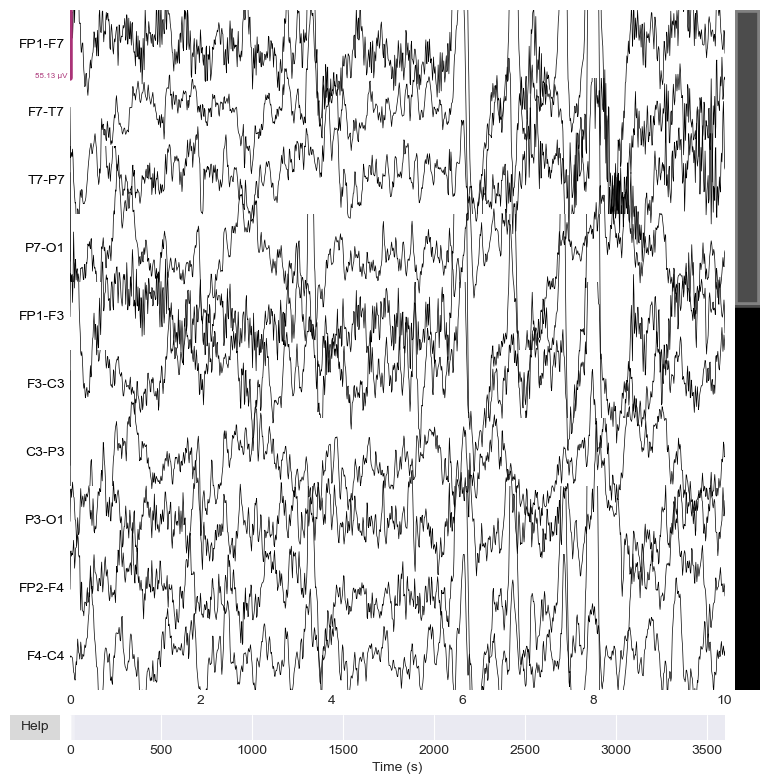

In [12]:
# Downsample the data to 128 Hz
downsampled_data = filtered_data.copy().resample(128, npad="auto")

# Plot downsampled signals
downsampled_data.plot(n_channels=10, scalings='auto', title='Downsampled EEG Signals', show=True)

### Handling Missing Data and Artifacts
It's common to have missing data or artifacts in EEG recordings. We need to inspect the data and handle these appropriately.

Missing data or bad channels: []
Setting channel interpolation method to {'eeg': 'spline'}.


C:\Users\Pouya\AppData\Local\Temp\ipykernel_24836\3592446945.py:5: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  cleaned_data = downsampled_data.copy().interpolate_bads()


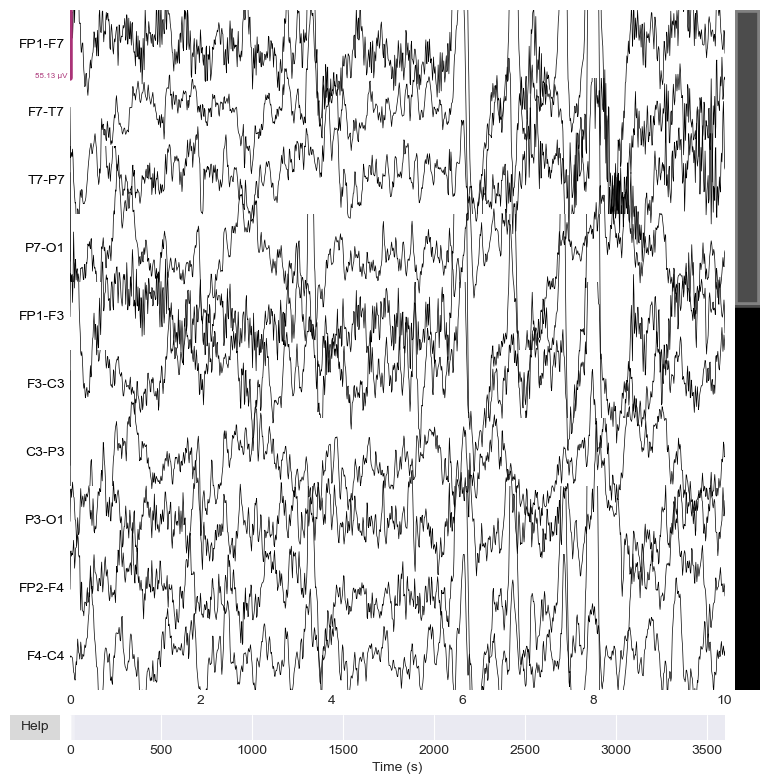

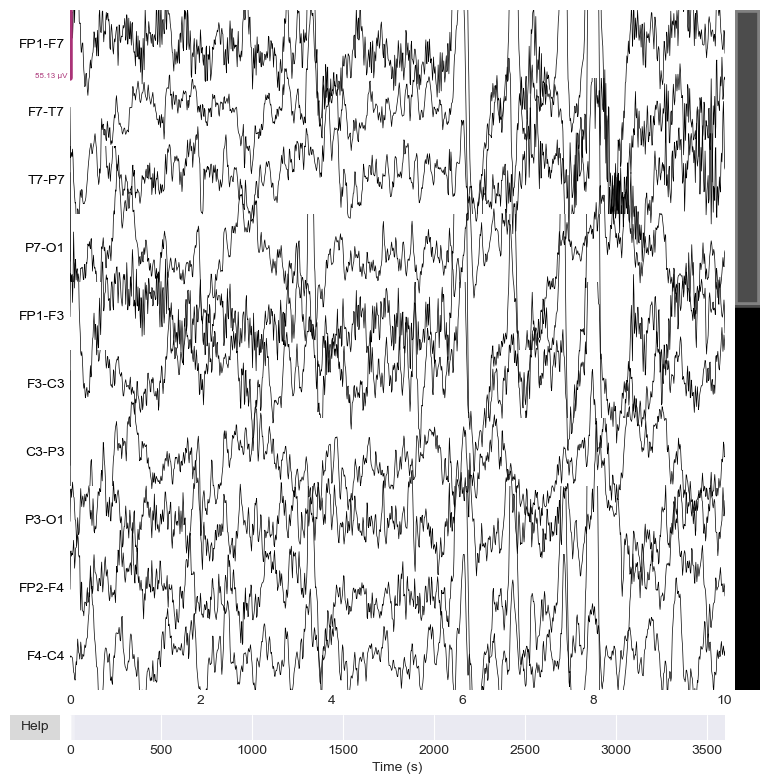

In [13]:
# Inspect for any missing data or flat channels
print("Missing data or bad channels:", raw_data.info['bads'])

# Interpolate bad channels
cleaned_data = downsampled_data.copy().interpolate_bads()

# Plot cleaned signals
cleaned_data.plot(n_channels=10, scalings='auto', title='Cleaned EEG Signals', show=True)

## Data Visualization and Exploration
To gain deeper insights, we can visualize the distribution of signal amplitudes, power spectral densities, and channel correlations.
### Visualizing Signal Amplitude Distribution

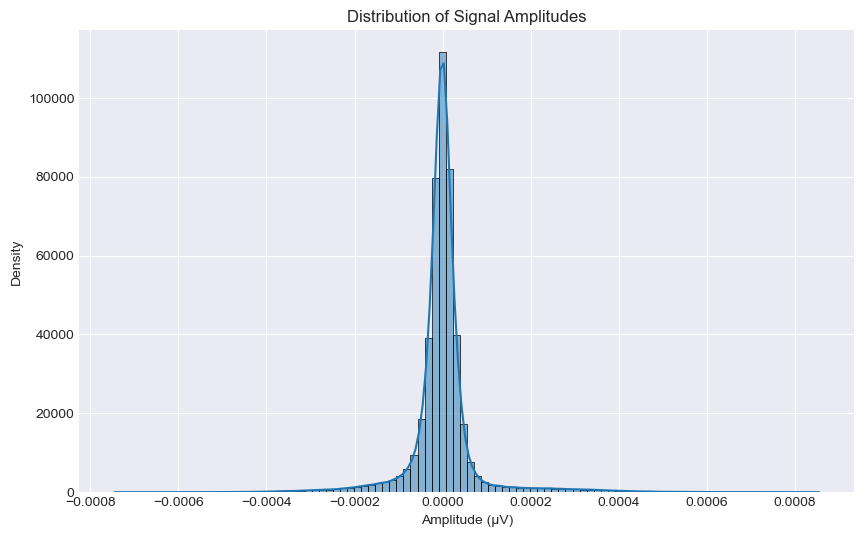

In [15]:
# Plot histogram of signal amplitudes
signal_data = cleaned_data.get_data()[0]  # Extract signal data from the first channel
plt.figure(figsize=(10, 6))
sns.histplot(signal_data, bins=100, kde=True)
plt.title('Distribution of Signal Amplitudes')
plt.xlabel('Amplitude (µV)')
plt.ylabel('Density')
plt.show()


### Power Spectral Density (PSD)
Power spectral density provides insights into the frequency content of the signals.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


C:\Users\Pouya\AppData\Local\Temp\ipykernel_24836\2119887728.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  cleaned_data.plot_psd(fmin=0.5, fmax=40.0, average=True)
C:\Users\Pouya\AppData\Roaming\Python\Python310\site-packages\mne\viz\utils.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


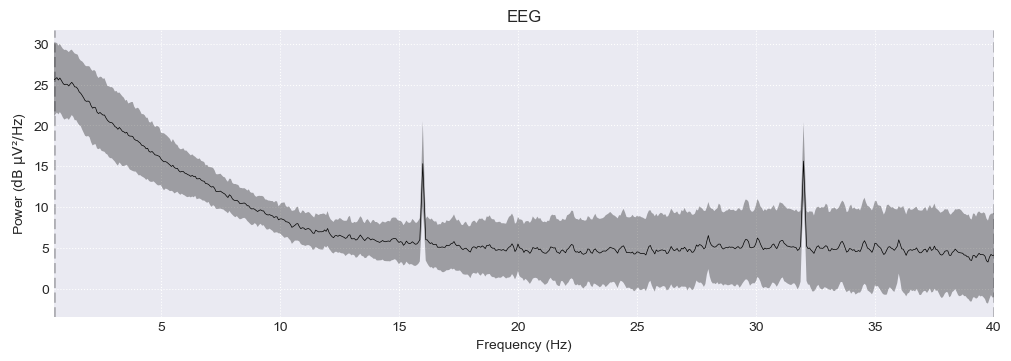

In [16]:
# Plot power spectral density
cleaned_data.plot_psd(fmin=0.5, fmax=40.0, average=True)

### Channel Correlation Matrix
Analyzing the correlation between channels can help understand the spatial relationships of the signals.

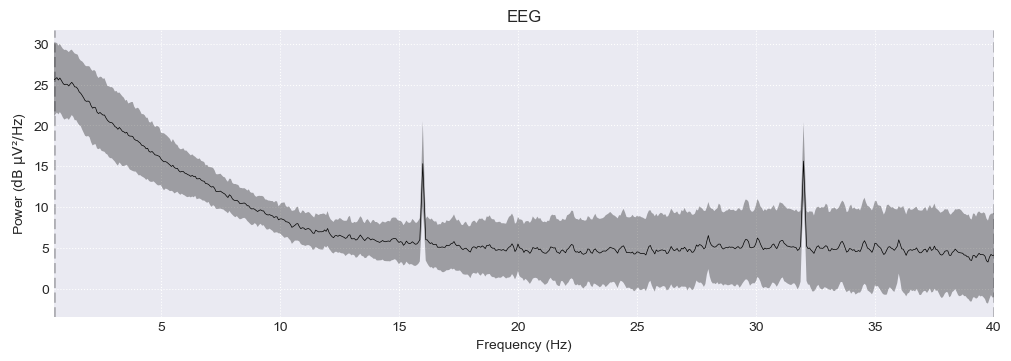

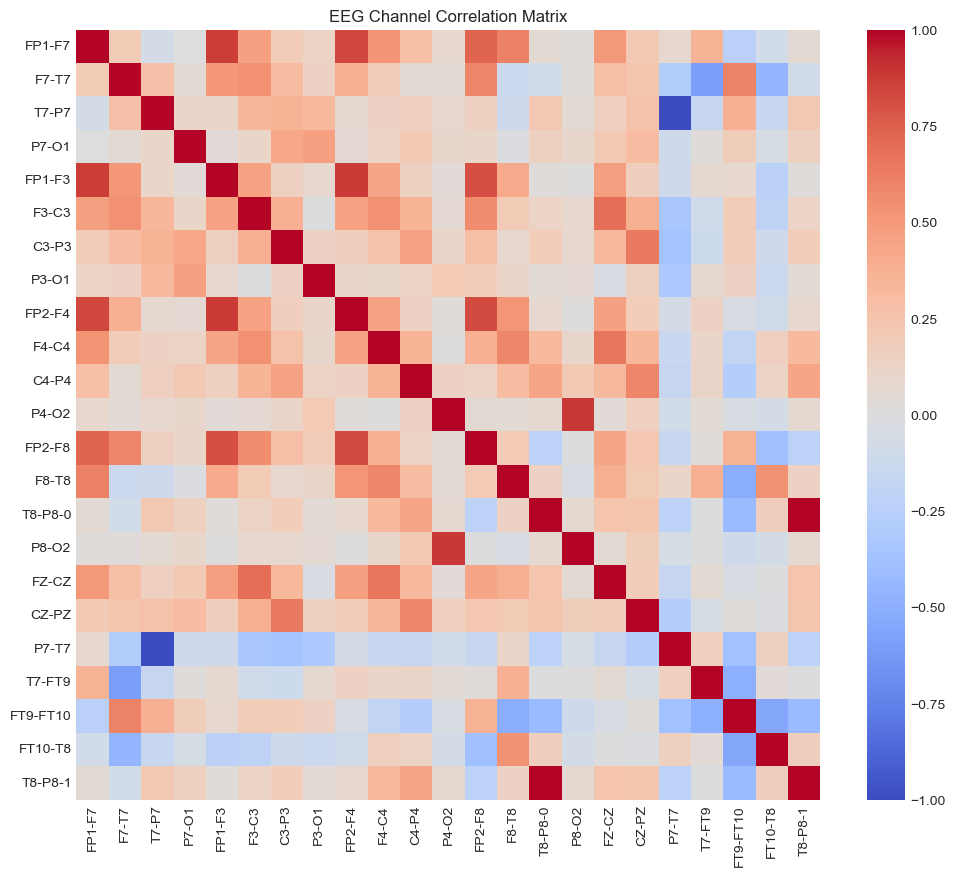

In [17]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(cleaned_data.get_data())

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', xticklabels=cleaned_data.ch_names, yticklabels=cleaned_data.ch_names)
plt.title('EEG Channel Correlation Matrix')
plt.show()

## Conclusion and Next Steps
In this guide, we successfully loaded the CHB-MIT EEG dataset, performed basic data preprocessing (filtering, downsampling, and cleaning), and explored various aspects of the data through visualization.

### Next Steps:
* Feature extraction: Derive features like power in specific frequency bands, entropy, and more.
* Model building: Use machine learning models to predict seizures based on the extracted features.
* Model evaluation: Assess the performance of your models using appropriate metrics.